In [57]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [58]:
dataset = 'model/keypoint_classifier/Alphabet_keys.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier_updated.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [79]:
NUM_CLASSES = 26

# Dataset reading

In [80]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [81]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [83]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [84]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_8 (Dropout)             │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,356 (5.30 KB)

 Trainable params: 1,356 (5.30 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [87]:
from tensorflow.keras.callbacks import  ReduceLROnPlateau
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',      # Metric to monitor
    factor=0.5,              # Reduce LR by this factor
    patience=5,              # Epochs with no improvement to wait
    min_lr=1e-6,             # Minimum LR
    verbose=1                # Print updates
)

In [88]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [89]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback, reduce_lr_callback]
)

Epoch 1/1000
125/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0478 - loss: 3.2678
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier_updated.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0513 - loss: 3.2558 - val_accuracy: 0.2073 - val_loss: 2.9900 - learning_rate: 0.0010
Epoch 2/1000
128/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1315 - loss: 2.9723
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier_updated.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1331 - loss: 2.9589 - val_accuracy: 0.2432 - val_loss: 2.5499 - learning_rate: 0.0010
Epoch 3/1000
128/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1882 - loss: 2.6209
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier_updated.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1899 - loss: 2.6122 - val_accuracy: 0.3414 - val_loss: 2.2018 - learning_rate: 0.0010
Epoch 4/1000
143/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - ac

In [90]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8905 - loss: 0.5815


In [91]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [92]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
[3.8777739e-02 1.3177214e-05 2.5975189e-09 7.0125629e-06 8.7926798e-03
 1.0595300e-07 1.0811567e-03 6.8765767e-05 2.4101585e-03 8.3753290e-03
 2.2558419e-01 2.2188961e-07 2.5660422e-06 1.6111106e-06 4.5915956e-05
 1.8958835e-11 3.7065885e-08 3.2550117e-04 5.8993898e-02 4.9573797e-01
 3.7781736e-06 1.9299551e-07 2.3749652e-11 1.4892888e-01 1.0123953e-02
 7.2526239e-04]
19


# Confusion matrix

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


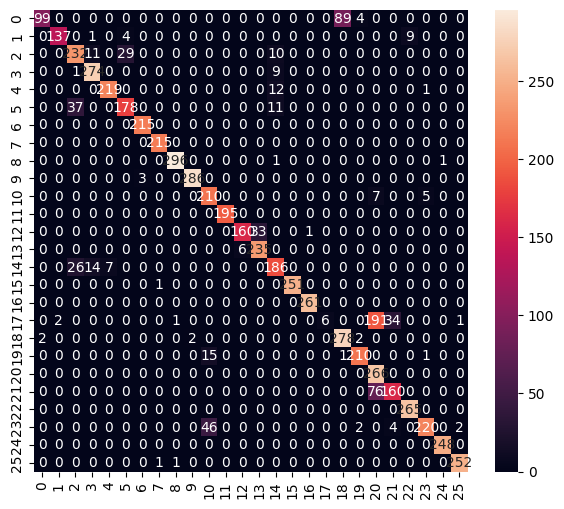

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.52      0.68       192
           1       0.99      0.91      0.94       151
           2       0.78      0.82      0.80       282
           3       0.91      0.96      0.94       284
           4       0.97      0.94      0.96       232
           5       0.84      0.79      0.81       226
           6       0.99      1.00      0.99       215
           7       0.99      1.00      1.00       215
           8       0.99      0.99      0.99       298
           9       0.99      0.99      0.99       289
          10       0.77      0.95      0.85       222
          11       1.00      1.00      1.00       195
          12       0.96      0.82      0.89       194
          13       0.88      0.98      0.92       241
          14       0.81      0.80      0.81       233
          15       1.00      1.00      1.00       252
          16       1.00      1.00      1.00       261
     

In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [94]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [95]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ARAVIN~1\AppData\Local\Temp\tmpv8bb2b3s\assets


INFO:tensorflow:Assets written to: C:\Users\ARAVIN~1\AppData\Local\Temp\tmpv8bb2b3s\assets


Saved artifact at 'C:\Users\ARAVIN~1\AppData\Local\Temp\tmpv8bb2b3s'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  2738405316208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2738390439536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2738394826528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2738390241520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2738403629536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2738403629184: TensorSpec(shape=(), dtype=tf.resource, name=None)


7540

# Inference test

In [96]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

c:\Softwares\All Programs\New\repo\lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [97]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [98]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [99]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 913 µs


In [100]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[3.87777276e-02 1.31772031e-05 2.59751420e-09 7.01255703e-06
 8.79267789e-03 1.05952914e-07 1.08115887e-03 6.87658394e-05
 2.41015898e-03 8.37532990e-03 2.25584015e-01 2.21889422e-07
 2.56604244e-06 1.61111075e-06 4.59159637e-05 1.89588380e-11
 3.70659592e-08 3.25501198e-04 5.89938797e-02 4.95738059e-01
 3.77817423e-06 1.92995529e-07 2.37496099e-11 1.48928836e-01
 1.01239523e-02 7.25262507e-04]
19
